# Context
With rise of social media coupled with the Covid-19 pandemic, cyberbullying has reached all time highs. We can combat this by creating models to automatically flag potentially harmful tweets as well as break down the patterns of hatred.

# About Dataset
As social media usage becomes increasingly prevalent in every age group, a vast majority of citizens rely on this essential medium for day-to-day communication. Social media’s ubiquity means that cyberbullying can effectively impact anyone at any time or anywhere, and the relative anonymity
of the internet makes such personal attacks more difficult to stop than traditional bullying.

On April 15th, 2020, UNICEF issued a warning in response to the increased risk of cyberbullying during the COVID-19 pandemic due to widespread school closures, increased screen time, and decreased face-to-face social interaction. The statistics of cyberbullying are outright alarming: 36.5% of middle and high school students have felt cyberbullied and 87% have observed cyberbullying, with effects ranging from decreased academic performance to depression to suicidal thoughts.

# Variables
In light of all of this, this dataset contains more than 47000 tweets labelled according to the class of cyberbullying:

__Age
Ethnicity
Gender
Religion
Other type of cyberbullying
Not cyberbullying__

# Objective
The objective of this project is to create a model that can automatically flag potentially harmful tweets as well as break down the patterns of hatred

# Importing Libraries

In [ ]:
!pip install emoji
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.1-py2.py3-none-any.whl size=351210 sha256=4b2833465303a3cade43f9905676039cc62814ce3afbb19ea6388afe1c49c77a
  Stored in directory: /root/.cache/pip/wheels/51/92/44/e2ef13f803aa08711819357e6de0c5fe67b874671141413565
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=5f6904d645d1dd3a8093e456515331b796211a18d91f5f93e107187f259b1ceb
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Succes

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import emoji
import string
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import pickle

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# membuat sesi baru
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.appName('UAS BIG DATA').getOrCreate()

# Getting data

In [ ]:
data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/BIG DATA/cyberbullying_tweets.csv", inferSchema=True, header=True)

# Initial Review

In [ ]:
data.show(10)

+--------------------+------------------+
|          tweet_text|cyberbullying_type|
+--------------------+------------------+
|In other words #k...| not_cyberbullying|
|Why is #aussietv ...| not_cyberbullying|
|@XochitlSuckkks a...| not_cyberbullying|
|@Jason_Gio meh. :...| not_cyberbullying|
|@RudhoeEnglish Th...| not_cyberbullying|
|@Raja5aab @Quicki...| not_cyberbullying|
|Itu sekolah ya bu...| not_cyberbullying|
|Karma. I hope it ...| not_cyberbullying|
|@stockputout ever...| not_cyberbullying|
|Rebecca Black Dro...| not_cyberbullying|
+--------------------+------------------+
only showing top 10 rows



In [ ]:
# melakukan filter csv sesuai dengan kategori cyberbullying

filtered_dataset = data.na.drop(subset=["cyberbullying_type", "tweet_text"])\
              .select(['tweet_text', 'cyberbullying_type']).dropDuplicates()\
              .filter(
                  (data.cyberbullying_type == "religion") |
                  (data.cyberbullying_type == "age") |
                  (data.cyberbullying_type == "gender") |
                  (data.cyberbullying_type == "ethnicity") |
                  (data.cyberbullying_type == "not_cyberbullying") |
                  (data.cyberbullying_type == "other_cyberbullying")
              )

filtered_dataset.show(10)

+--------------------+------------------+
|          tweet_text|cyberbullying_type|
+--------------------+------------------+
|@Zoebeastt Wow th...| not_cyberbullying|
|RT @_CHYnese__: M...| not_cyberbullying|
|ALL GRATE THINGS ...| not_cyberbullying|
|@Shervyn i don't ...| not_cyberbullying|
|@mutaSawwif @Tawh...| not_cyberbullying|
|BULLSHIT. how the...| not_cyberbullying|
|RT @YG_WINNER: [!...| not_cyberbullying|
|YAY! GO CASH AND ...| not_cyberbullying|
|Hills councillor'...| not_cyberbullying|
|Stalk aka respond...| not_cyberbullying|
+--------------------+------------------+
only showing top 10 rows



In [ ]:
# memasukkan file csv ke dalam temporary table / view dengan nama tweets
filtered_dataset.createOrReplaceTempView("tweets")

In [ ]:
# print schema dan juga isi dari tabel tweets
sql = spark.sql("SELECT * FROM tweets")

sql.printSchema()
sql.show(5)

root
 |-- tweet_text: string (nullable = true)
 |-- cyberbullying_type: string (nullable = true)

+--------------------+------------------+
|          tweet_text|cyberbullying_type|
+--------------------+------------------+
|@Zoebeastt Wow th...| not_cyberbullying|
|RT @_CHYnese__: M...| not_cyberbullying|
|ALL GRATE THINGS ...| not_cyberbullying|
|@Shervyn i don't ...| not_cyberbullying|
|@mutaSawwif @Tawh...| not_cyberbullying|
+--------------------+------------------+
only showing top 5 rows



In [ ]:
# konversi dari tabel sql spark ke dataframe pandas
data = sql.toPandas()

In [ ]:
# menampilkan info data dari tabel tweets
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46487 entries, 0 to 46486
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          46487 non-null  object
 1   cyberbullying_type  46487 non-null  object
dtypes: object(2)
memory usage: 726.5+ KB


In [ ]:
data.head()

,tweet_text,cyberbullying_type
0,"@Zoebeastt Wow that undocumented, confirmation...",not_cyberbullying
1,"RT @_CHYnese__: Miserable Martha's , Pathetic ...",not_cyberbullying
2,"ALL GRATE THINGS ARE SIMPLE, AND MANY CAN BE E...",not_cyberbullying
3,@Shervyn i don't even know what that is! oh gosh.,not_cyberbullying
4,@mutaSawwif @TawheedNetwork_ Horse shit. The Q...,not_cyberbullying


# Checking Missing Values

In [ ]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

## No Missing Values found!

In [ ]:
data['cyberbullying_type'].value_counts()

age                    7847
not_cyberbullying      7835
religion               7806
other_cyberbullying    7733
gender                 7663
ethnicity              7603
Name: cyberbullying_type, dtype: int64

## Renaming columns for better understanding

In [ ]:
data = data.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [ ]:
data.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Adding Encoded column for sentiments

In [ ]:
data["sentiment_encoded"] = data['sentiment'].replace({"religion": 1, "age": 2, "ethnicity": 3, "gender": 4, "other_cyberbullying": 5,"not_cyberbullying": 6})

In [ ]:
data.head()

,text,sentiment,sentiment_encoded
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6


In [ ]:
stop_words = set(stopwords.words('english'))

# Preprocessing of Text

## Function to Remove Emojis

In [ ]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

## Function to Convert text to lowercase, remove (/r, /n  characters), URLs, non-utf characters, Numbers, punctuations,stopwords

In [ ]:
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

## Function to remove contractions

In [ ]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

## Function to Clean Hashtags

In [ ]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

## Function to Filter Special Characters such as $, &

In [ ]:
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

## Function to remove mutiple sequence spaces

In [ ]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)


## Function to apply stemming to words

In [ ]:
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

## Function to apply lemmatization to words

In [ ]:
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

## Function to Preprocess the text by applying all above functions

In [ ]:
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [ ]:
data['cleaned_text'] = data['text'].apply(preprocess)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text
0,"@Zoebeastt Wow that undocumented, confirmation...",not_cyberbullying,6,wow undocu confirm biasstink comment sure conv...
1,"RT @_CHYnese__: Miserable Martha's , Pathetic ...",not_cyberbullying,6,rt miser martha pathet patti amp bullshit becki
2,"ALL GRATE THINGS ARE SIMPLE, AND MANY CAN BE E...",not_cyberbullying,6,grate thing simpl mani express singl word free...
3,@Shervyn i don't even know what that is! oh gosh.,not_cyberbullying,6,even know oh gosh
4,@mutaSawwif @TawheedNetwork_ Horse shit. The Q...,not_cyberbullying,6,hors shit quran say apostaci accept multipl ha...


## Cleaned text added

## Dealing with Duplicates

In [ ]:
data["cleaned_text"].duplicated().sum()

2964

In [ ]:
data.drop_duplicates("cleaned_text", inplace=True)

# Duplicates removed

# Tokenization

In [ ]:
data['tweet_list'] = data['cleaned_text'].apply(word_tokenize)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list
0,"@Zoebeastt Wow that undocumented, confirmation...",not_cyberbullying,6,wow undocu confirm biasstink comment sure conv...,"[wow, undocu, confirm, biasstink, comment, sur..."
1,"RT @_CHYnese__: Miserable Martha's , Pathetic ...",not_cyberbullying,6,rt miser martha pathet patti amp bullshit becki,"[rt, miser, martha, pathet, patti, amp, bullsh..."
2,"ALL GRATE THINGS ARE SIMPLE, AND MANY CAN BE E...",not_cyberbullying,6,grate thing simpl mani express singl word free...,"[grate, thing, simpl, mani, express, singl, wo..."
3,@Shervyn i don't even know what that is! oh gosh.,not_cyberbullying,6,even know oh gosh,"[even, know, oh, gosh]"
4,@mutaSawwif @TawheedNetwork_ Horse shit. The Q...,not_cyberbullying,6,hors shit quran say apostaci accept multipl ha...,"[hors, shit, quran, say, apostaci, accept, mul..."


# Checking length of various tweet texts

In [ ]:
text_len = []
for text in data.tweet_list:
    tweet_len = len(text)
    text_len.append(tweet_len)
data['text_len'] = text_len

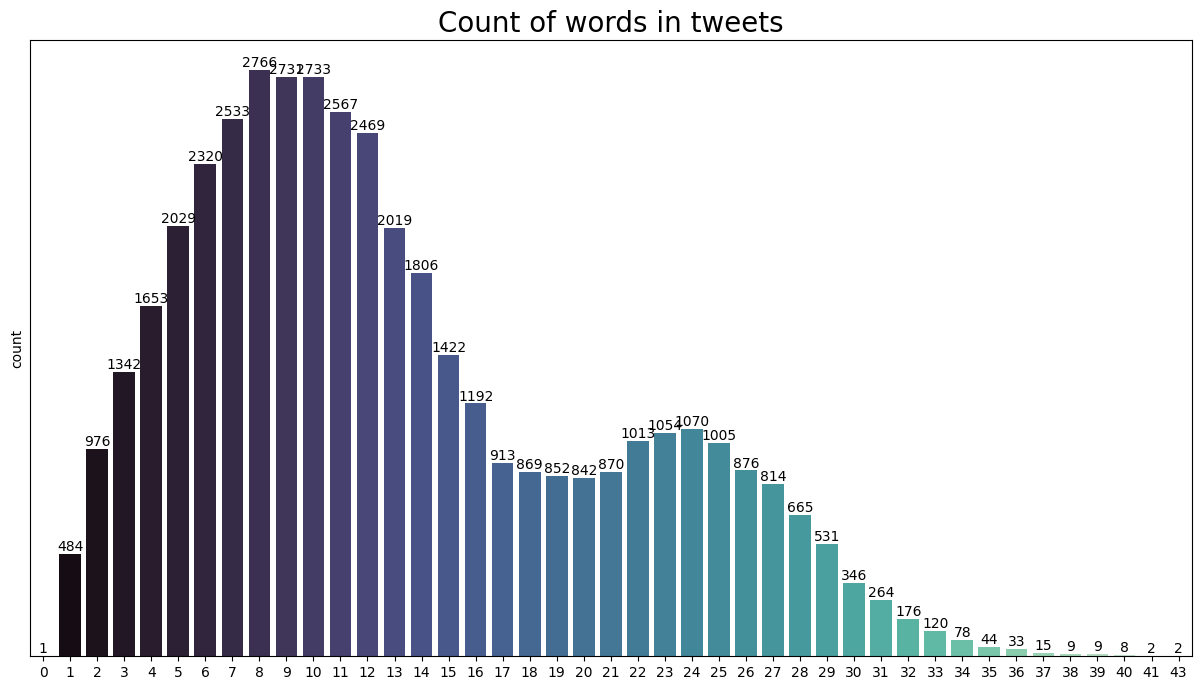

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=data, palette='mako')
plt.title('Count of words in tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Removing text without words

In [ ]:
data = data[data['text_len']!=0]

In [ ]:
data.shape

(43522, 6)

# Function to create WordCloud

In [ ]:
def plot_wordcloud(cyberbullying_type):
    string = ""
    for i in data[data.sentiment == cyberbullying_type].cleaned_text.values:
        string = string + " " + i.strip()

    custom_mask = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/BIG DATA/twitter_mask.png'))
    mask_colors = ImageColorGenerator(custom_mask)
    wordcloud = WordCloud(background_color ='white',max_words=2000, max_font_size=256,
               random_state=42, width=custom_mask.shape[1],height=custom_mask.shape[0],
                mask = custom_mask,min_font_size = 10).generate(string)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cyberbullying_type)
    plt.show()
    del string

# Splitting data based on sentiment for Data Exploration

In [ ]:
not_cyberbullying_type = data[data['sentiment']=='not_cyberbullying']
gender_type = data[data['sentiment']=='gender']
religion_type = data[data['sentiment']=='religion']
other_cyberbullying_type = data[data['sentiment']=='other_cyberbullying']
age_type = data[data['sentiment']=='age']
ethnicity_type = data[data['sentiment']=='ethnicity']

# Exploratory Data Analysis

# Gender Based Cyberbullying

In [ ]:
gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
top20_gender = pd.DataFrame(gender.most_common(20))
top20_gender.columns = ['Top Words','Count']
top20_gender.style.background_gradient(cmap='Greens')

,Top Words,Count
0,joke,4895
1,rape,3834
2,gay,3629
3,call,1319
4,make,1230
5,rt,1196
6,woman,1128
7,bitch,1087
8,femal,1057
9,peopl,933


Text(0.5, 1.0, 'Top 20 words in Gender Cyberbullying')

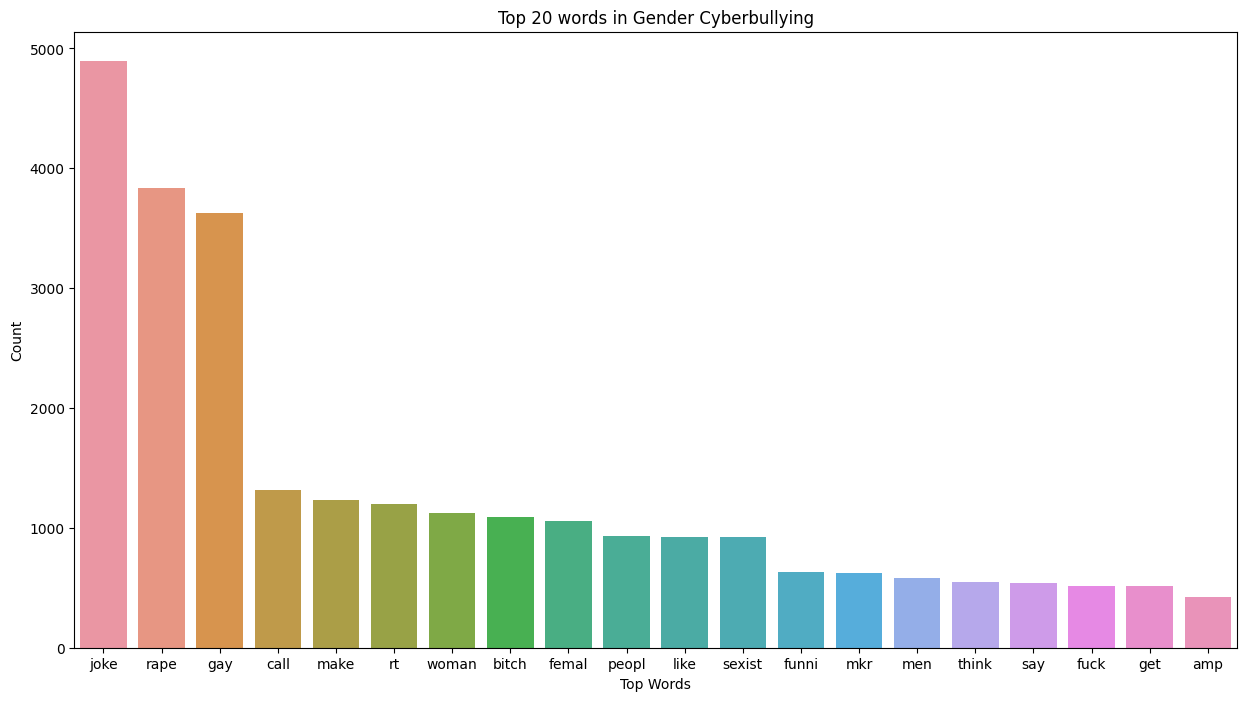

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_gender, y="Count", x="Top Words")
plt.title("Top 20 words in Gender Cyberbullying")

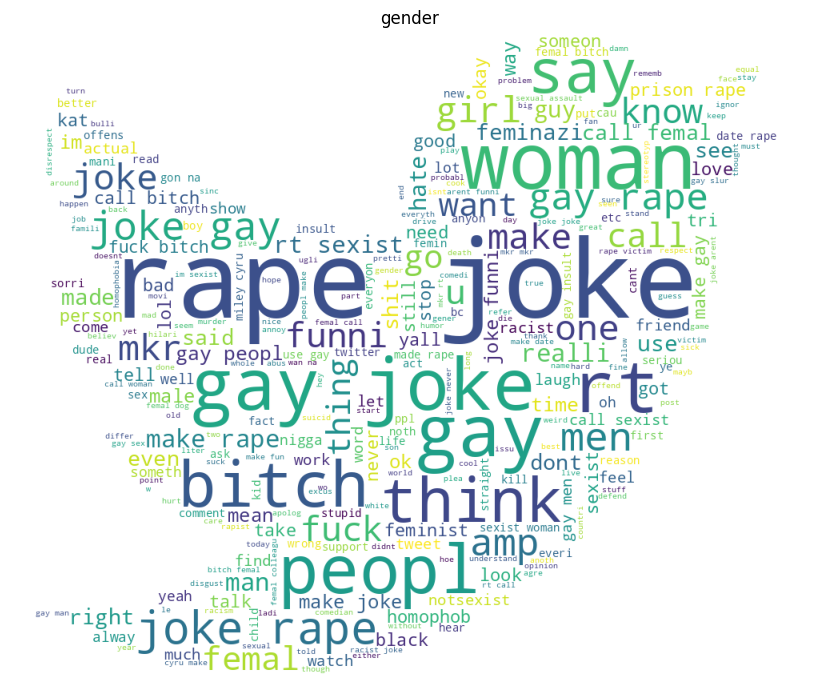

In [ ]:
plot_wordcloud('gender')

# Religion Based Cyberbullying

In [ ]:
religion = Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
top20_religion = pd.DataFrame(religion.most_common(20))
top20_religion.columns = ['Top Words','Count']
top20_religion.style.background_gradient(cmap='Greens')

,Top Words,Count
0,muslim,4510
1,idiot,2998
2,islam,2404
3,christian,2034
4,u,1898
5,terrorist,1348
6,like,1237
7,right,1230
8,support,1204
9,woman,1198


Text(0.5, 1.0, 'Top 20 words in Religion Cyberbullying')

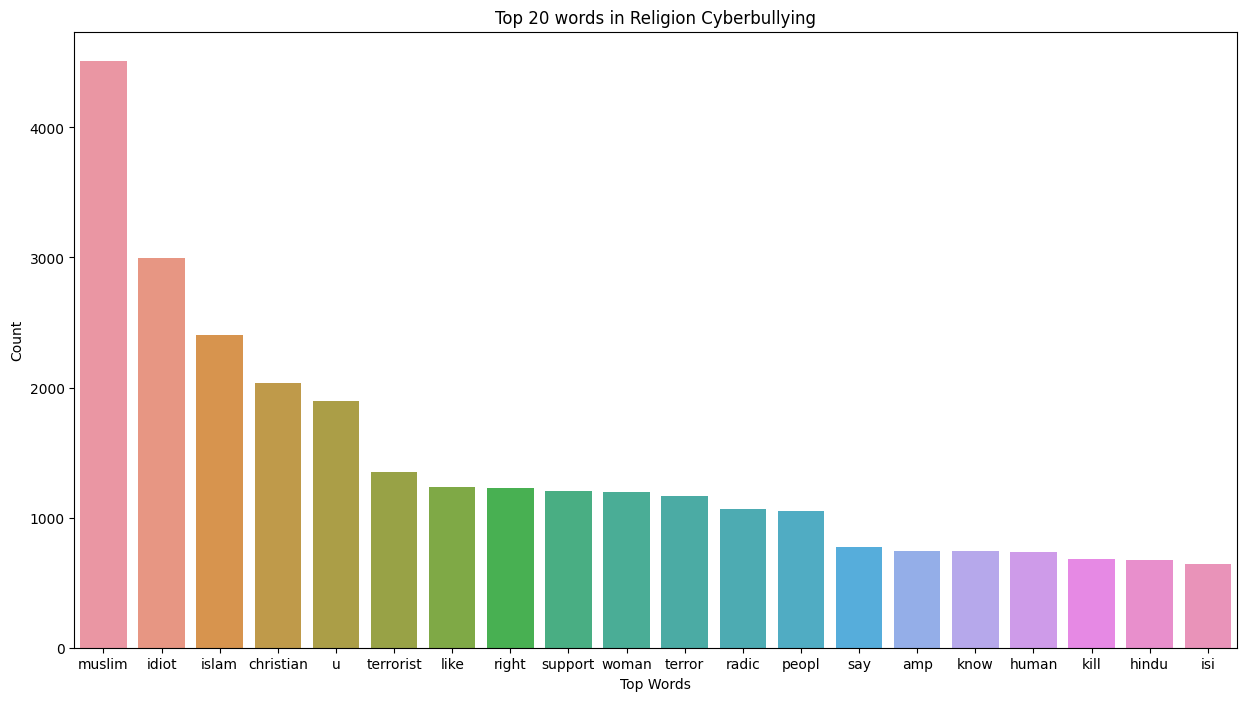

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_religion, y="Count", x="Top Words")
plt.title("Top 20 words in Religion Cyberbullying")

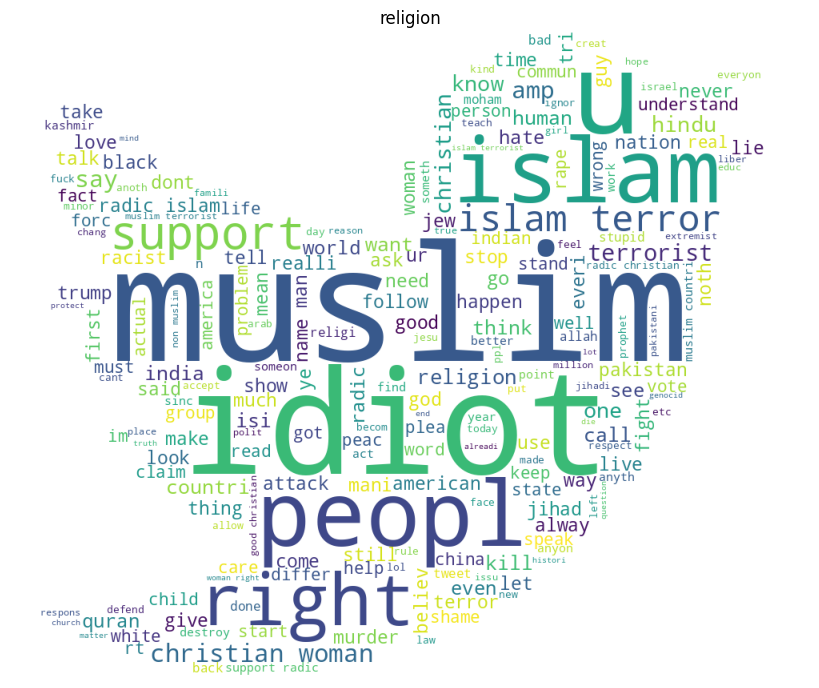

In [ ]:
plot_wordcloud('religion')

# Age based Cyberbullying

In [ ]:
age = Counter([item for sublist in age_type['tweet_list'] for item in sublist])
top20_age = pd.DataFrame(age.most_common(20))
top20_age.columns = ['Top Words','Count']
top20_age.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,8726
1,school,8263
2,high,4768
3,girl,4519
4,like,2016
5,one,1020
6,get,1018
7,peopl,904
8,got,822
9,kid,787


Text(0.5, 1.0, 'Top 20 words in Age Cyberbullying')

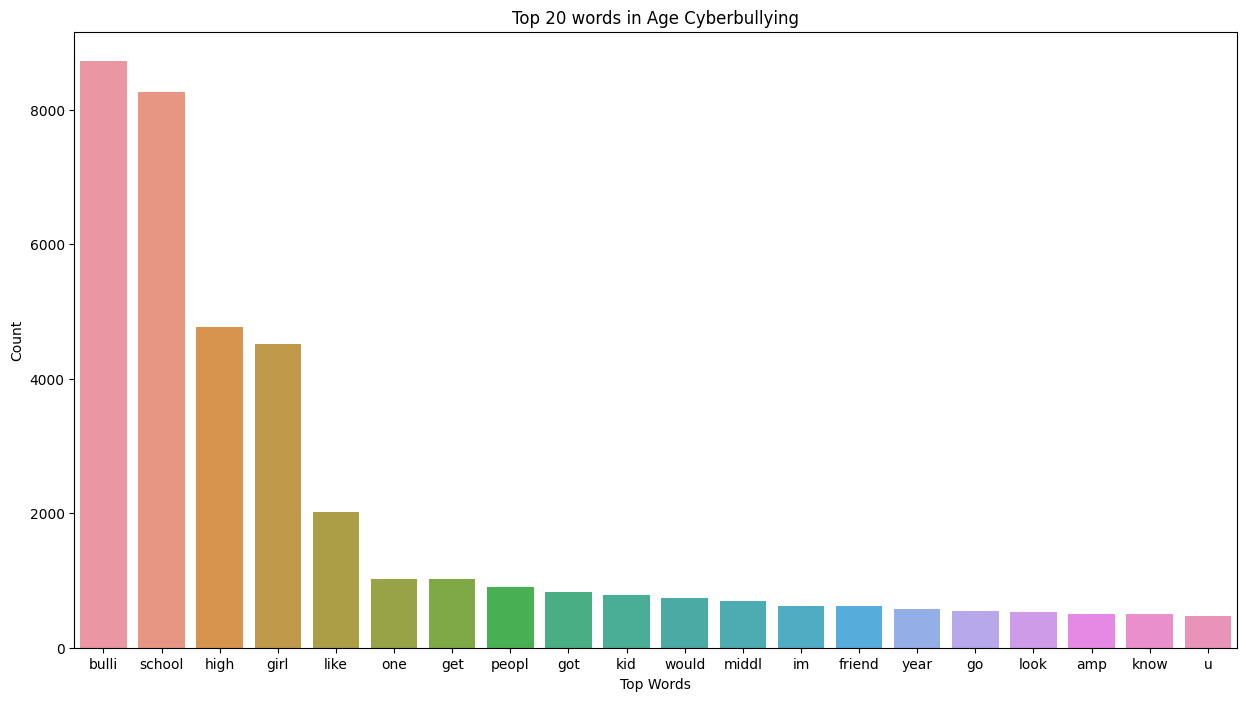

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_age, y="Count", x="Top Words")
plt.title("Top 20 words in Age Cyberbullying")

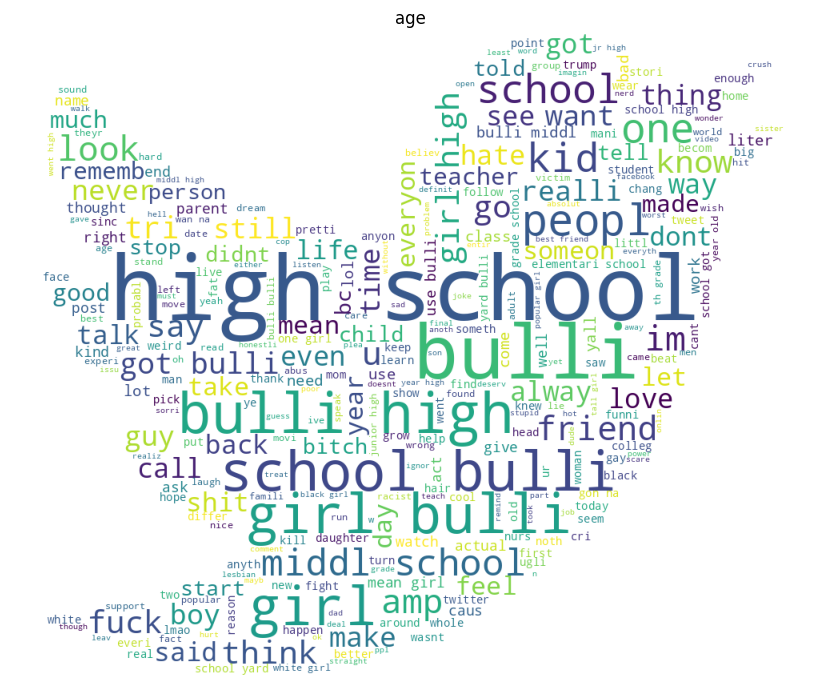

In [ ]:
plot_wordcloud('age')

# Ethnicity based Cyberbullying

In [ ]:
ethnicity = Counter([item for sublist in ethnicity_type['tweet_list'] for item in sublist])
top20_ethnicity = pd.DataFrame(ethnicity.most_common(20))
top20_ethnicity.columns = ['Top Words','Count']
top20_ethnicity.style.background_gradient(cmap='Greens')

,Top Words,Count
0,fuck,5643
1,nigger,5199
2,dumb,4789
3,as,2087
4,u,2028
5,black,1988
6,white,1395
7,call,1240
8,rt,1081
9,peopl,1079


Text(0.5, 1.0, 'Top 20 words in Ethnicity Cyberbullying')

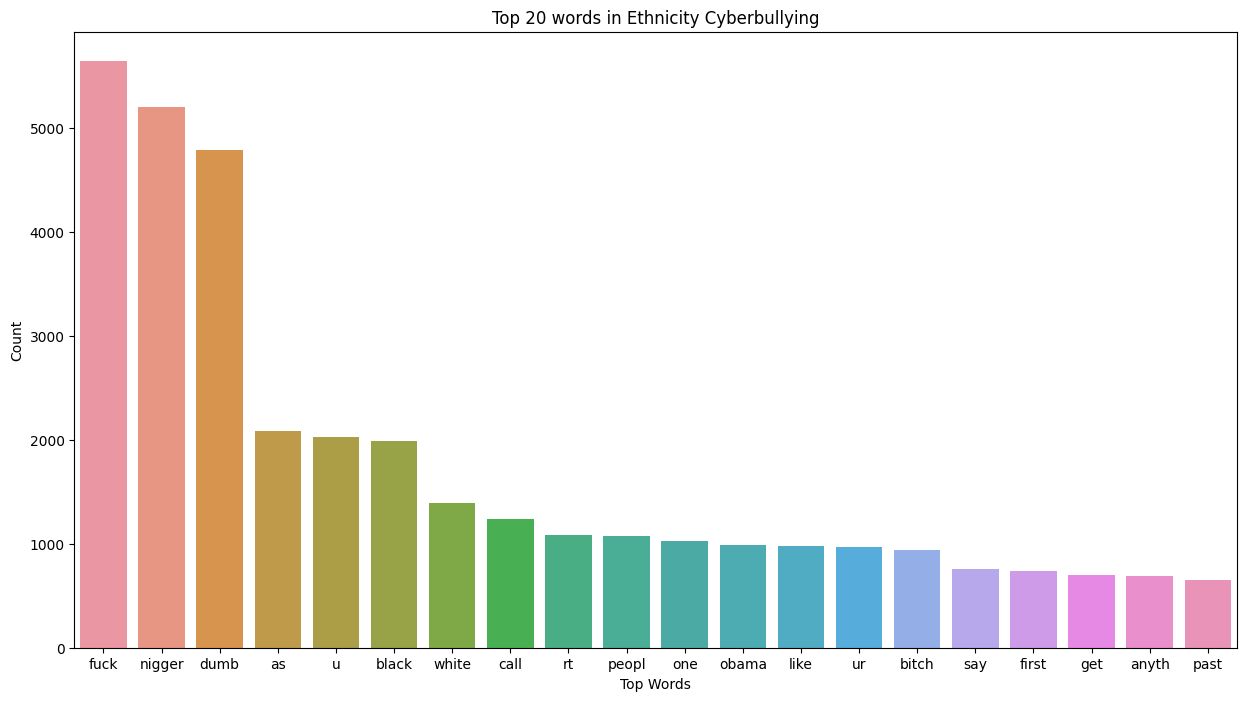

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_ethnicity, y="Count", x="Top Words")
plt.title("Top 20 words in Ethnicity Cyberbullying")

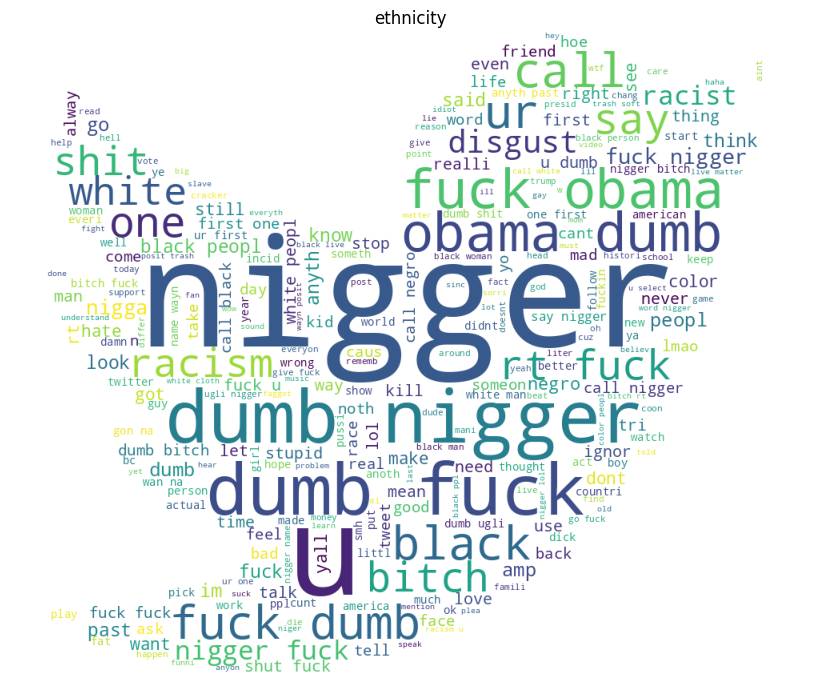

In [ ]:
plot_wordcloud('ethnicity')

# Other types of Cyberbullying

In [ ]:
other_cyberbullying = Counter([item for sublist in other_cyberbullying_type['tweet_list'] for item in sublist])
top20_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(20))
top20_other_cyberbullying.columns = ['Top Words','Count']
top20_other_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,850
1,rt,772
2,fuck,507
3,like,430
4,get,423
5,peopl,373
6,go,314
7,know,271
8,would,258
9,think,258


Text(0.5, 1.0, 'Top 20 words in Other Cyberbullying')

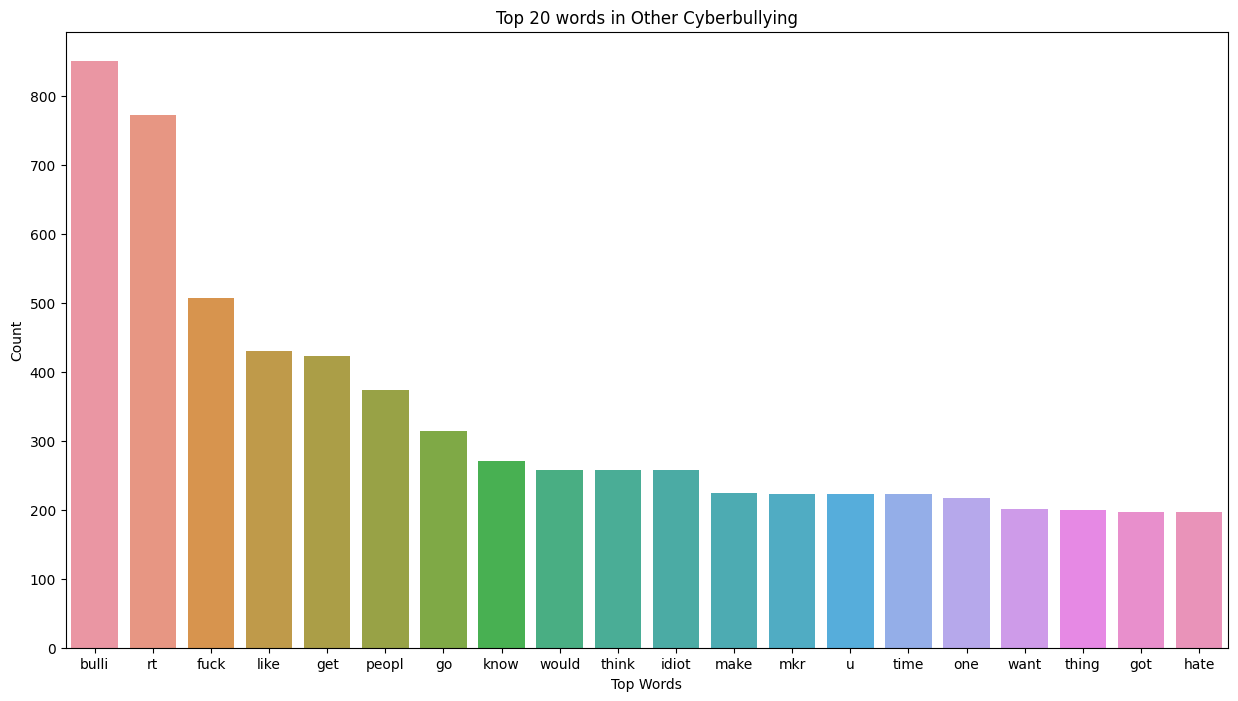

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_other_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Other Cyberbullying")

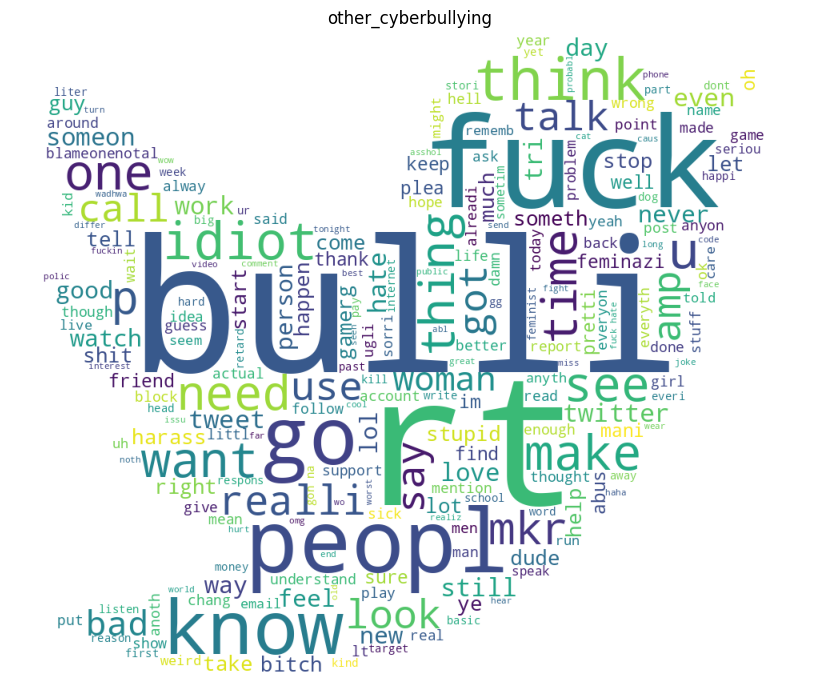

In [ ]:
plot_wordcloud('other_cyberbullying')

# Tweets without Cyberbullying

In [ ]:
not_cyberbullying = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
top20_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(20))
top20_not_cyberbullying.columns = ['Top Words','Count']
top20_not_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,mkr,1608
1,bulli,1084
2,rt,685
3,get,380
4,like,371
5,school,369
6,go,336
7,kat,285
8,would,255
9,one,232


Text(0.5, 1.0, 'Top 20 words in Not Cyberbullying')

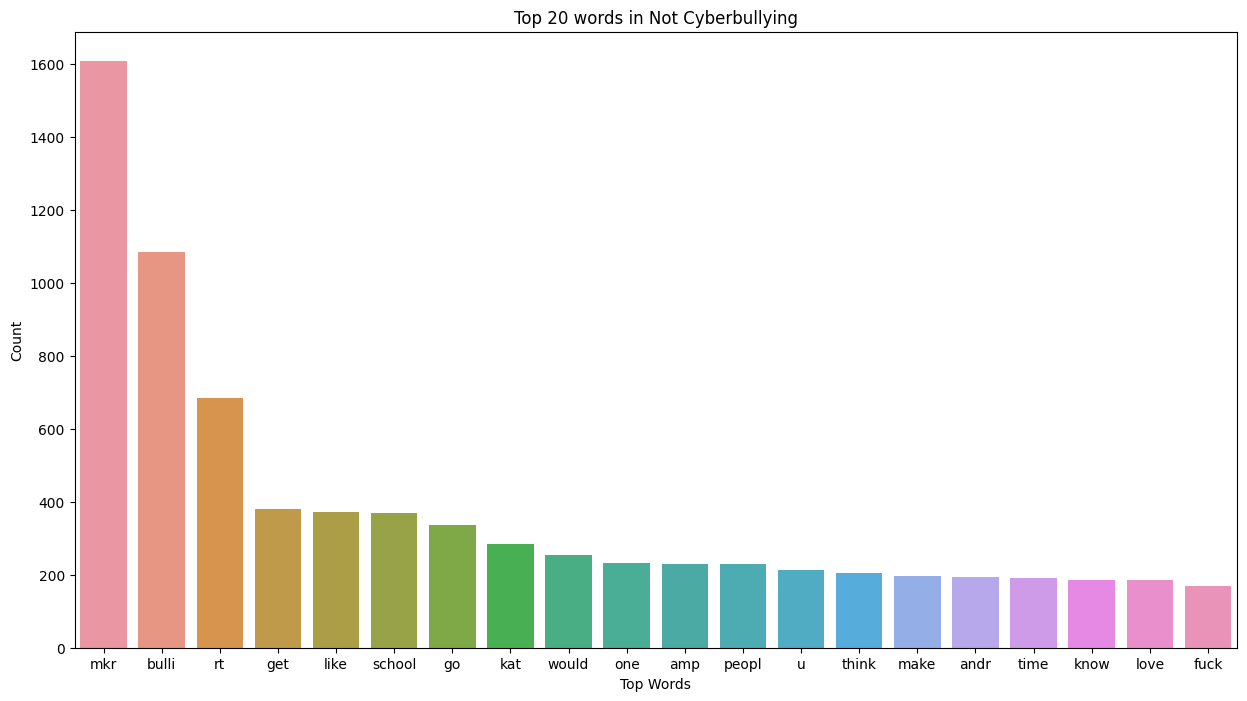

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_not_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Not Cyberbullying")

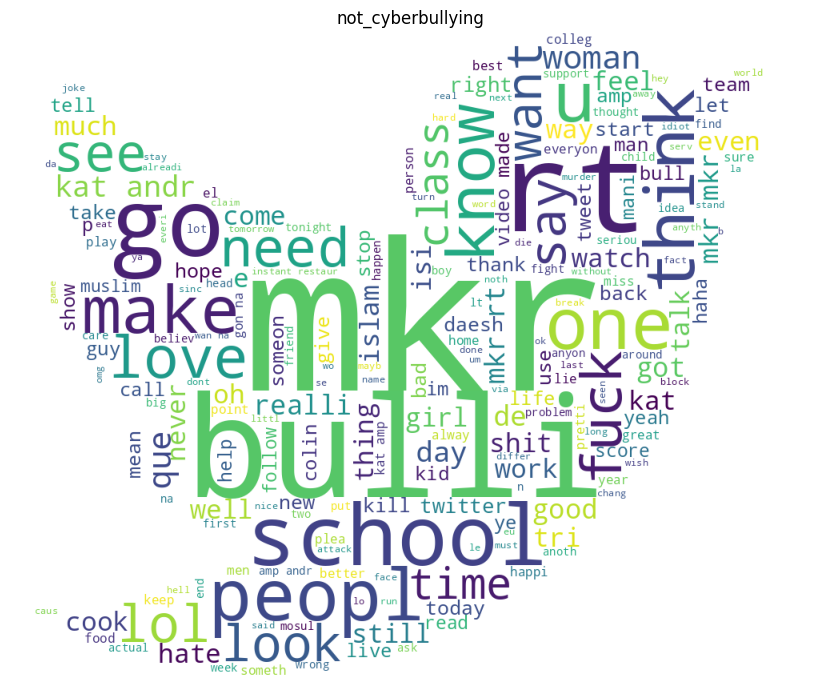

In [ ]:
plot_wordcloud('not_cyberbullying')

In [ ]:
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list,text_len
0,"@Zoebeastt Wow that undocumented, confirmation...",not_cyberbullying,6,wow undocu confirm biasstink comment sure conv...,"[wow, undocu, confirm, biasstink, comment, sur...",8
1,"RT @_CHYnese__: Miserable Martha's , Pathetic ...",not_cyberbullying,6,rt miser martha pathet patti amp bullshit becki,"[rt, miser, martha, pathet, patti, amp, bullsh...",8
2,"ALL GRATE THINGS ARE SIMPLE, AND MANY CAN BE E...",not_cyberbullying,6,grate thing simpl mani express singl word free...,"[grate, thing, simpl, mani, express, singl, wo...",13
3,@Shervyn i don't even know what that is! oh gosh.,not_cyberbullying,6,even know oh gosh,"[even, know, oh, gosh]",4
4,@mutaSawwif @TawheedNetwork_ Horse shit. The Q...,not_cyberbullying,6,hors shit quran say apostaci accept multipl ha...,"[hors, shit, quran, say, apostaci, accept, mul...",12


In [ ]:
sentiments = ["religion", "age", "ethnicity", "gender", "other_cyberbullying","not_cyberbullying"]

# Splitting Data into Train and Test Sets

In [ ]:
X,Y = data['cleaned_text'],data['sentiment_encoded']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify =Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30465,) (30465,) (13057,) (13057,)


## tf-idf Vectorization

In [ ]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

(30465, 28557)
(13057, 28557)


# Trying Different ML Models

## Logistic Regression

In [ ]:
log_reg = LogisticRegression()

In [ ]:
log_cv_score = cross_val_score(log_reg,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)

In [ ]:
mean_log_cv = np.mean(log_cv_score)
mean_log_cv

0.8301184963034517

## Support Vector Classifier

In [ ]:
lin_svc = LinearSVC()

In [ ]:
lin_svc_cv_score = cross_val_score(lin_svc,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

0.8259469672693323

## Naive Bayes Classifier

In [ ]:
multiNB = MultinomialNB()

In [ ]:
multiNB_cv_score = cross_val_score(multiNB,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_multiNB_cv = np.mean(multiNB_cv_score)
mean_multiNB_cv

0.6995756241817522

## Decison Tree Classifier

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree_cv_score = cross_val_score(dtree,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)
mean_dtree_cv = np.mean(dtree_cv_score)
mean_dtree_cv

0.8140514393225349

## By trying different models we can see logistic regression, svm and random forest classifier performed similarly, so among these we will go with svm model as it is more generalised and light

## Fine Tuning Support Vector Classifier

In [ ]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
             'loss':['hinge','squared_hinge'],
             'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [ ]:
grid_search.best_estimator_

LinearSVC(C=1, loss='hinge')

In [ ]:
grid_search.best_score_

0.8313273537412946

# Model Evaluation

In [ ]:
lin_svc.fit(X_train_tf,y_train)
y_pred = lin_svc.predict(X_test_tf)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

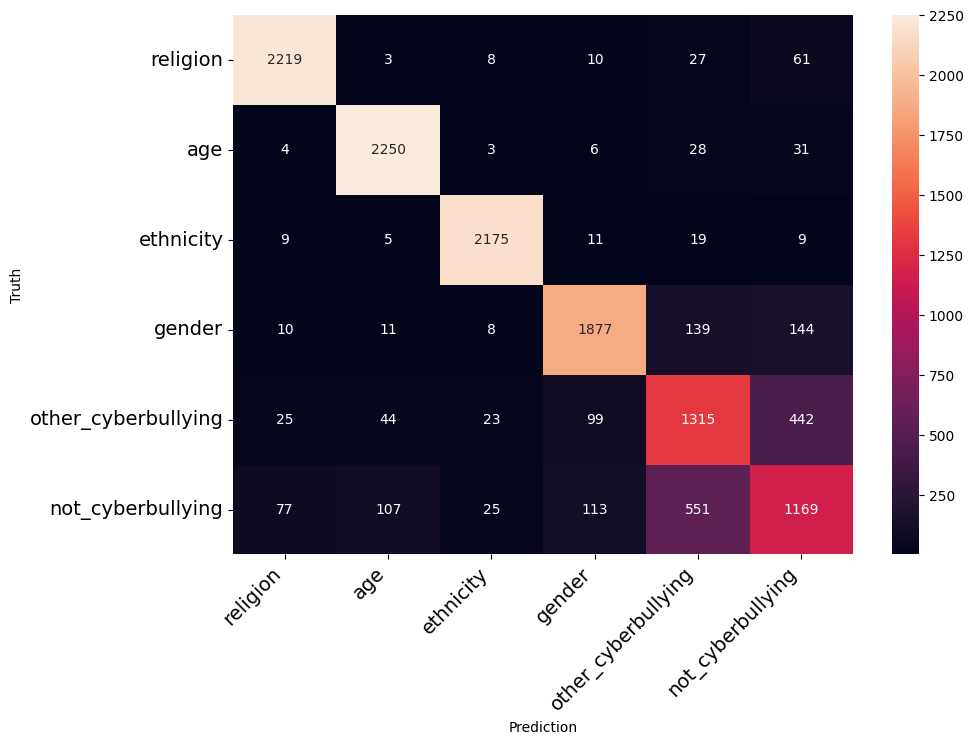

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print_confusion_matrix(cm,sentiments)

In [ ]:
print('Classification Report:\n',classification_report(y_test, y_pred, target_names=sentiments))

Classification Report:
                      precision    recall  f1-score   support

           religion       0.95      0.95      0.95      2328
                age       0.93      0.97      0.95      2322
          ethnicity       0.97      0.98      0.97      2228
             gender       0.89      0.86      0.87      2189
other_cyberbullying       0.63      0.68      0.65      1948
  not_cyberbullying       0.63      0.57      0.60      2042

           accuracy                           0.84     13057
          macro avg       0.83      0.83      0.83     13057
       weighted avg       0.84      0.84      0.84     13057

